In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [2]:
# Actual labels
y_true = ['Ripe'] * 18 + ['Overripe'] * 14 + ['Unripe'] * 17 + ['None'] *0

# Predicted labels 
y_pred = ['Ripe'] * 18 + ['Ripe'] * 3 + ['Overripe'] * 9 + ['None'] * 2 + ['Unripe'] * 16 + ['None'] * 1

# Classes
classes = ['Ripe', 'Overripe', 'Unripe', 'None']

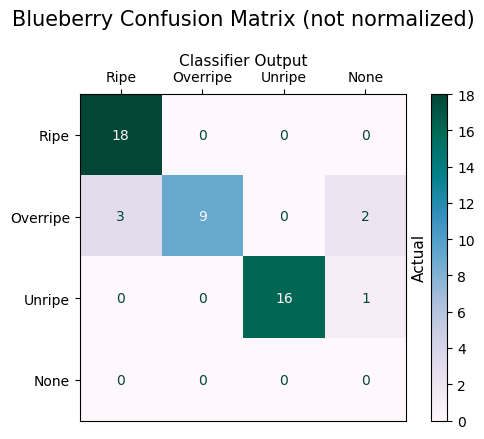

<Figure size 640x480 with 0 Axes>

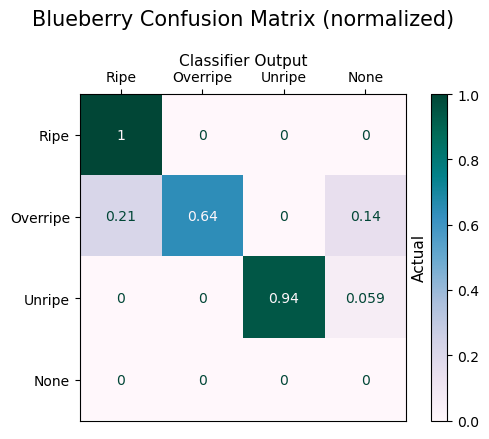

              precision    recall  f1-score   support

        Ripe       0.00      0.00      0.00         0
    Overripe       1.00      0.64      0.78        14
      Unripe       0.86      1.00      0.92        18
        None       1.00      0.94      0.97        17

    accuracy                           0.88        49
   macro avg       0.71      0.65      0.67        49
weighted avg       0.95      0.88      0.90        49



/home/aj/miniconda3/envs/blueberryjammin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aj/miniconda3/envs/blueberryjammin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aj/miniconda3/envs/blueberryjammin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [3]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=classes)
cm_norm = confusion_matrix(y_true, y_pred, labels=classes, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes)
disp.plot(cmap=plt.cm.PuBuGn)
plt.title('Blueberry Confusion Matrix (not normalized)', fontsize=15, pad=20)
plt.xlabel('Classifier Output', fontsize=11)
plt.ylabel('Actual', fontsize=11)
#Customizations
plt.gca().xaxis.set_label_position('top')
plt.gca().yaxis.set_label_position('right')
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)

plt.figure()
disp_norm.plot(cmap=plt.cm.PuBuGn)
plt.title('Blueberry Confusion Matrix (normalized)', fontsize=15, pad=20)
plt.xlabel('Classifier Output', fontsize=11)
plt.ylabel('Actual', fontsize=11)
#Customizations
plt.gca().xaxis.set_label_position('top')
plt.gca().yaxis.set_label_position('right')
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)

plt.show()
print(classification_report(y_true, y_pred, target_names=classes))

In [4]:
import sys
sys.path.append("/home/aj/robosys24/BlueberryJam/src")

from adjust_colorspace import *
import cv2 as cv
import numpy as np


def main(path, name): 
    # img_path = f'{path}'
    img = cv.imread(path)
    if img is not None:
        img = cv.cvtColor(img, cv.COLOR_BGR2LAB)
        img = adjust_colorspace(img)
        print(cv.imwrite(f'/home/aj/robosys24/BlueberryJam/img/test_set/{name}.jpg', img))
    else:
        raise FileNotFoundError(f"Could not load image at{path}")

In [5]:
main("/home/aj/robosys24/BlueberryJam/img/test_set/overripe/OR_02.jpg",'overripe_1')
main("/home/aj/robosys24/BlueberryJam/img/test_set/ripe/R_01.jpg",'ripe_1')
main("/home/aj/robosys24/BlueberryJam/img/test_set/ripe/R_02.jpg",'ripe_2')
main("/home/aj/robosys24/BlueberryJam/img/test_set/unripe/UR_01.jpg",'unripe_1')
main("/home/aj/robosys24/BlueberryJam/img/test_set/unripe/UR_02.jpg",'unripe_2')

True
True
True
True
True


In [3]:
import sys
sys.path.append("/home/aj/robosys24/BlueberryJam/src")

from preprocess_img import *
from Classifier import *
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
# overripe ripe general
MASKS = [[(0, 60, 0), (38, 145, 100)],[(0, 135, 0), (180, 255, 150)],[(0, 0, 0), (180, 255, 105)]]

In [4]:
def add_centroids(masked_imgs,img_rgb,mask_list):
    processed_imgs = []
    centroid_results = []
    existing_centroids = []
    for i, img in enumerate(mask_list):
        # overripe, ripe, underripe - i

        processed, centroids = perform_centroiding(img,img_rgb)
        processed_imgs.append(processed)

        curr_mask_centroids = [(k[0], k[1]) for k in centroids] # (cX,cY)           

        #compared centroids to centroid_results (keep in mind which mask should have priority (overripe))
        # TODO: check if centroid is too close or the same as an existing centroid in another mask
        if len(centroid_results) > 0: # only check duplicates if centroids already exist

            #intersections = set(existing_centroids) & set(curr_mask_centroids)
            for j in reversed(curr_mask_centroids):
                #print(f"existing centroids is {existing_centroids}")
                is_close = pythag_centroid(j,existing_centroids,thresh=200)

                if not is_close:
                    continue
                #favors centroids already tracked (by extension overripe)
                #print(f"popping:{j}")
                idx = curr_mask_centroids.index(j)
                centroids.pop(idx)
                curr_mask_centroids.pop(idx)
        existing_centroids.extend(curr_mask_centroids)            
        centroid_results.append(centroids)
        annotation_space = img_rgb.copy()
    for i,centroid_list in enumerate(centroid_results):
        print(i,centroid_list)
        for centroid in centroid_list:
            loc = centroid[1]
            # berry = Blueberry(ripeness=0,belt=1,actuation_time=0.0,location_linear=abs(calculate_linear_location(loc)) )
            #overripe, ripe, underripe
            if i ==0:#ovveripe
                # berry.ripeness = 2
                similarities = [0.0,1.0,0.0] #ripe, overripe, underripe
                is_ripe =1
            elif i ==1: #ripe
                # berry.ripeness = 1
                similarities = [1.0,0.0,0.0]
                is_ripe = 0
            elif i ==3: #underripe
                # berry.ripeness = -1
                similarities = [0.0,0.0,0.0]
                is_ripe = 2
            else:
                similarities = [0.0,0.0,1.0]
                is_ripe = 2 #for full masked image

            #berry.ripeness = classify_single(img_rgb,annotation_space,centroid)
            # if berry.ripeness == -5:
            #     continue
            annotate_and_show(annotation_space,centroid,similarities,is_ripe)
    plt.figure()
    plt.imshow(annotation_space)

0 []
1 [(409, 524, [377, 492, 63, 63]), (102, 497, [71, 466, 60, 60]), (254, 464, [221, 431, 64, 64]), (188, 438, [151, 401, 72, 72]), (377, 427, [346, 396, 61, 61]), (191, 364, [158, 331, 64, 64]), (317, 294, [288, 265, 56, 56]), (384, 274, [355, 245, 57, 57]), (126, 282, [93, 249, 64, 64]), (168, 193, [132, 157, 71, 71]), (334, 190, [303, 159, 60, 60]), (402, 185, [362, 145, 78, 78]), (80, 154, [47, 121, 65, 65]), (146, 134, [108, 96, 74, 74]), (273, 127, [243, 97, 59, 59]), (345, 93, [309, 57, 70, 70]), (211, 71, [180, 40, 61, 61]), (297, 38, [263, 4, 66, 66])]
2 []
3 []
0 []
1 [(69, 582, [35, 548, 66, 66]), (217, 566, [186, 535, 61, 61]), (324, 522, [290, 488, 67, 67]), (136, 454, [105, 423, 60, 60]), (374, 432, [341, 399, 65, 65]), (420, 289, [388, 257, 63, 63]), (337, 279, [302, 244, 68, 68]), (131, 281, [99, 249, 62, 62]), (27, 247, [0, 216, 60, 60]), (119, 217, [86, 184, 65, 65]), (202, 199, [173, 170, 56, 56]), (305, 160, [274, 129, 61, 61]), (391, 157, [357, 123, 67, 67]), (1

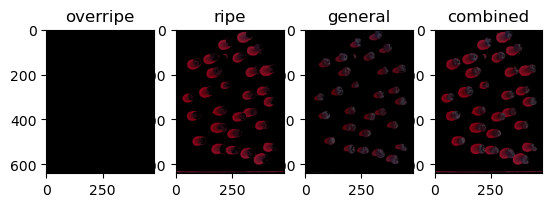

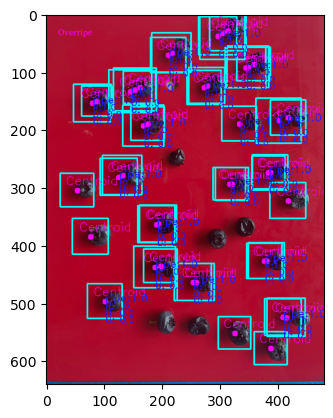

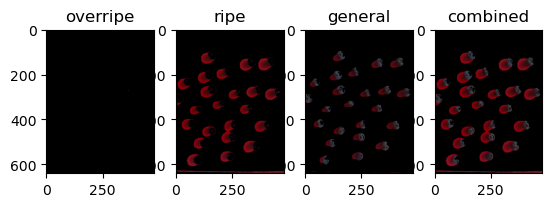

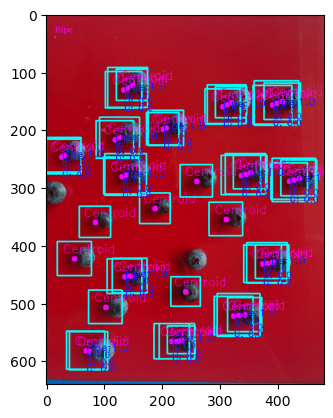

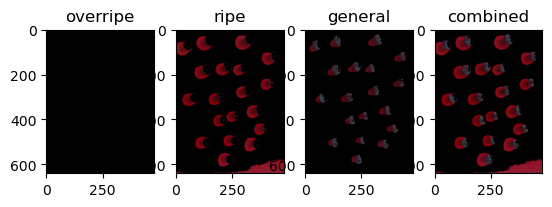

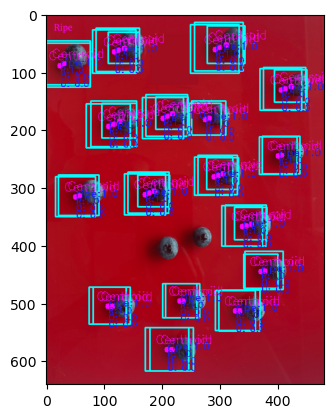

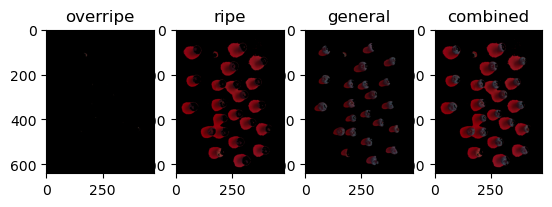

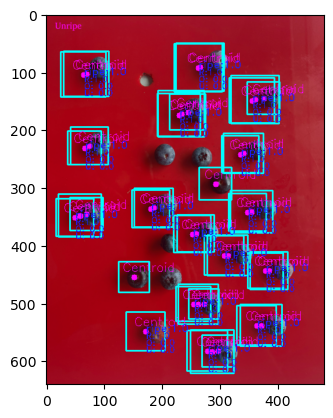

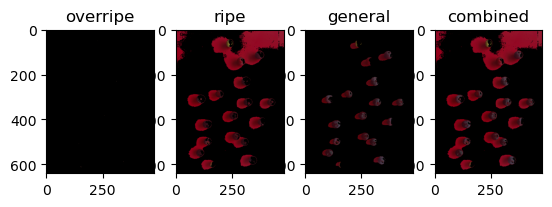

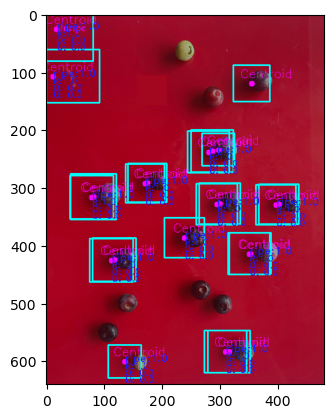

In [5]:

for i in range(1,6):
    # /home/aj/robosys24/BlueberryJam/img/test_set/CI_1.0.jpg
    img_path = f'img/test_set/TS_{i}.jpg'
    full_path = '/home/aj/robosys24/BlueberryJam/' + img_path
    image = cv.imread(full_path)
    
    if image is None:
        #print("no image found at: " +img_path)
        continue
    else: 
        masked_imgs,img_rgb,mask_list = apply_multi_bg(MASKS, path=img_path)
        plt.figure()
        plt.subplot(1,4,1)
        plt.imshow(masked_imgs[0])
        plt.title("overripe")
        
        plt.subplot(1,4,2)
        plt.title("ripe")
        plt.imshow(masked_imgs[1])
        
        plt.subplot(1,4,3)
        plt.title("general")
        plt.imshow(masked_imgs[2])
        
        plt.subplot(1,4,4)
        plt.title("combined")
        plt.imshow(masked_imgs[3])
        add_centroids(masked_imgs,img_rgb,mask_list)